# COVID-19 Data Analysis

## COVID-19 Data

1. https://github.com/CSSEGISandData/COVID-19
2. https://github.com/covid19-eu-zh/covid19-eu-data

## Useful resources

1. https://coronavirus.jhu.edu/map.html
2. https://docs.conda.io/projects/conda/en/latest/_downloads/843d9e0198f2a193a3484886fa28163c/conda-cheatsheet.pdf
3. https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

## Install pandas

In [86]:
#%pip install --upgrade pandas

<img src="images/pandas.jpg" />

In [87]:
import pandas as pd
pd.__version__

'1.1.4'

## COVID-19 Data Analysis (World / per Country)

In [88]:
CONFIRMED = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
DEATHS = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
RECOVERED = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [89]:
confirmed = pd.read_csv(CONFIRMED)
deaths = pd.read_csv(DEATHS)
recovered = pd.read_csv(RECOVERED)

In [90]:
confirmed.shape

(271, 316)

In [91]:
q = (confirmed['Country/Region'] == 'Poland') | (confirmed['Country/Region'] == 'Ukraine')
confirmed.loc[q]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20
207,NaN,Poland,51.9194,19.1451,0,0,0,0,0,0,...,796798,819262,843475,861331,876333,909066,924422,941112,958416,973593
248,NaN,Ukraine,48.3794,31.1656,0,0,0,0,0,0,...,600152,614986,629850,642215,653442,665968,680132,695755,712249,728834


In [92]:
confirmed_grouped = confirmed.drop(['Province/State', 'Lat', 'Long'], 1).groupby('Country/Region')
recovered_grouped = recovered.drop(['Province/State', 'Lat', 'Long'], 1).groupby('Country/Region')
deaths_grouped = deaths.drop(['Province/State', 'Lat', 'Long'], 1).groupby('Country/Region')

total_confirmed = confirmed_grouped.sum().iloc[:,[-1]].reset_index()
total_recovered = recovered_grouped.sum().iloc[:,[-1]].reset_index()
total_deaths = deaths_grouped.sum().iloc[:,[-1]].reset_index()

#q2 = last_deaths.iloc[:,[-1]].idxmax()
#last_deaths.loc[q2]

total_confirmed.sort_values(total_confirmed.columns[-1],ascending=False).head(5)

,Country/Region,11/28/20
176,US,13244417
79,India,9392919
23,Brazil,6290272
62,France,2260789
141,Russia,2223500


In [93]:
def _covid19_stats_for(country, name, data):
    if country:
        query = data['Country/Region'] == country
        data = data.loc[query]
        
    data = (data
          .transpose()[4:]
          .sum(axis='columns')
          .map(int))
    
    return pd.DataFrame(
        data = data,
        columns = [name],
        index = pd.to_datetime(data.index)
    )


def covid19_stats_for(country=None):
    return pd.concat((
        _covid19_stats_for(country, 'Confirmed', confirmed),
        _covid19_stats_for(country, 'Deaths', deaths),
        _covid19_stats_for(country, 'Recovered', recovered)
    ), axis='columns')    

In [94]:
def death_rate(df):
    return (df.tail(1)['Deaths'] / df.tail(1)['Confirmed']) * 100

def recovered_rate(df):
    return (df.tail(1)['Recovered'] / df.tail(1)['Confirmed']) * 100

In [95]:
df = covid19_stats_for('Poland')
#death_rate(df)
df

,Confirmed,Deaths,Recovered
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0
...,...,...,...
2020-11-24,909066,14314,454717
2020-11-25,924422,14988,469527
2020-11-26,941112,15568,494869
2020-11-27,958416,16147,516636


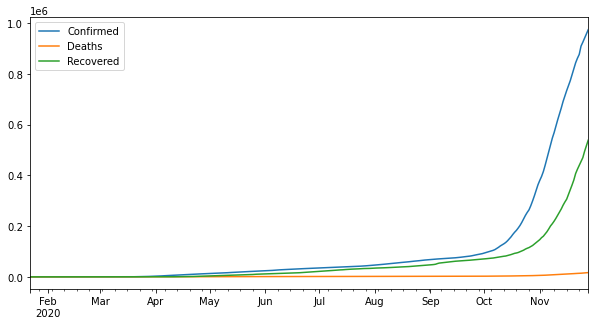

In [96]:
df.plot(subplots=False, sharey=True, sharex=True, figsize=(10,5))

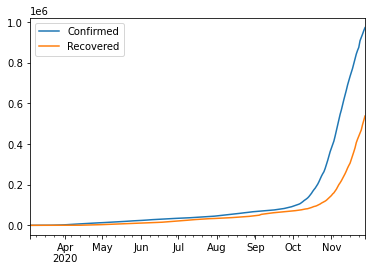

In [97]:
c = df['Confirmed']
r = df['Recovered']

#r.index -= pd.Timedelta(days=20)

cr = pd.concat((
    c['2020-03-04':],
    r['2020-03-04':]
), axis='columns')

cr.plot()

In [98]:
c = c['2020-03-04':]
r = r['2020-03-04':]

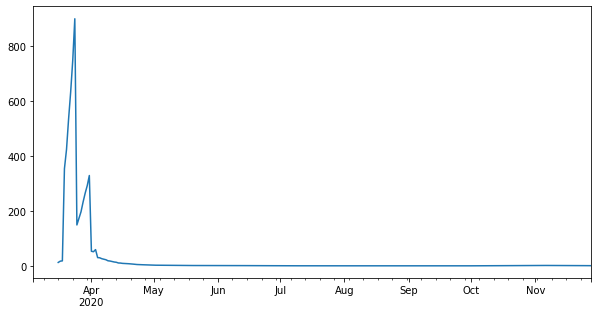

In [99]:
(c / r).plot(figsize=(10,5))

In [100]:
(c/r).median()

2.0517528194978922

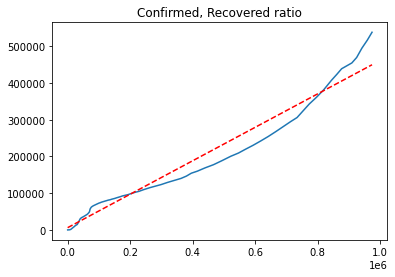

In [101]:
import matplotlib.pyplot as plt
import numpy as np

x = c[:len(r)]
y = r

model = np.polyfit(x, y, 1)
trend = np.poly1d(model)

plt.title('Confirmed, Recovered ratio')
plt.plot(x, y, label='data')
plt.plot(x, trend(x), color='red', linestyle='--', label='trend')
plt.show()

## Linear Regression (Supervised Learning algorithm)

Goal: Find the best line fit

**y = a*x + b**

- **a**: slope. Meaning how much the y value increases for each x value.
- **b**: y intercept. Where the line crosses the y axis.
- **x**: feature
- **y**: label

a = (y2 - y1) / (x2 - x1)

<img src="images/linear_regression.png" />

## COVID-19 Number of deaths prediction based on number of confirmed cases

In [102]:
train_df = df['2020-03-04':'2020-08-01'].rename_axis('Date').reset_index()
test_df = df['2020-08-02':].rename_axis('Date').reset_index()

x_train = train_df[["Confirmed"]]
y_train = train_df["Deaths"]

x_test = test_df[["Confirmed"]]
y_test = test_df["Deaths"]

In [103]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(x_train, y_train)
acc = lr.score(x_test, y_test)
print('Accuracy: \n', acc)

print('Coefficient(a): \n', lr.coef_)
print('Intercept(b): \n', lr.intercept_)

print(f"y = {lr.coef_[0]:.4f}*confirmed_cases + ({lr.intercept_:.4f})")

Accuracy: 
 -4.911392988500042
Coefficient(a): 
 [0.04112983]
Intercept(b): 
 26.064105895494663
y = 0.0411*confirmed_cases + (26.0641)


In [104]:
lr = LinearRegression(fit_intercept=False).fit(x_train, y_train)
acc = lr.score(x_test, y_test)
print('Accuracy: \n', acc)

print('Coefficient(a): \n', lr.coef_)
print('Intercept(b): \n', lr.intercept_)

print(f"y = {lr.coef_[0]:.4f}*confirmed_cases")

Accuracy: 
 -5.295447042665337
Coefficient(a): 
 [0.04198909]
Intercept(b): 
 0.0
y = 0.0420*confirmed_cases


In [105]:
y_pred = lr.predict(x_test)

predictions = pd.concat([test_df, pd.DataFrame(y_pred, columns=["Predicted Deaths"])], axis=1)
predictions = predictions.set_index("Date")
predictions

,Confirmed,Deaths,Recovered,Predicted Deaths
Date,,,,
2020-08-02,46894,1731,34709,1969.036312
2020-08-03,47469,1732,34881,1993.180037
2020-08-04,48149,1738,35056,2021.732617
2020-08-05,48789,1756,35321,2048.605634
2020-08-06,49515,1774,35642,2079.089712
...,...,...,...,...
2020-11-24,909066,14314,454717,38170.852637
2020-11-25,924422,14988,469527,38815.637079
2020-11-26,941112,15568,494869,39516.434964


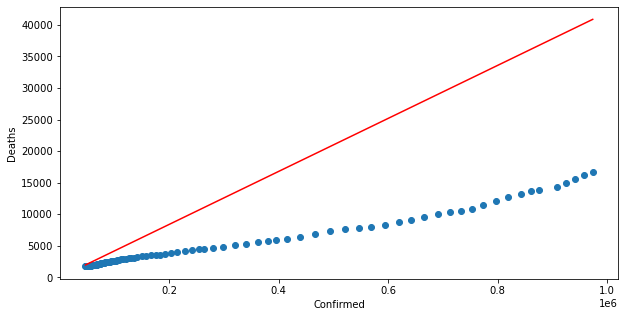

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.xlabel("Confirmed")
plt.ylabel("Deaths")
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred, c='r')
plt.show()

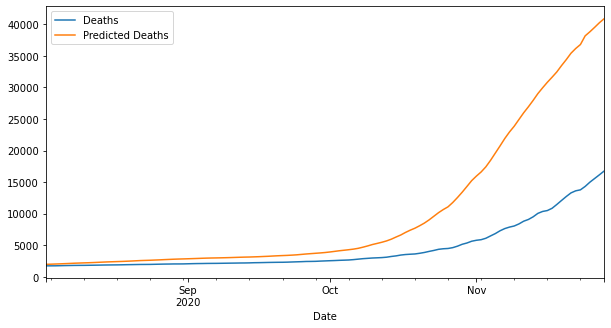

In [107]:
predictions[['Deaths', 'Predicted Deaths']].plot(figsize=(10,5))